In [116]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import re

import gensim
from gensim import corpora
from gensim.models import Word2Vec
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from wordcloud import WordCloud
# import jellyfish
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score
import lightgbm


df = pd.read_parquet('_df_for_modeling.parquet')
def data_cleanup(df):

    df.dropna(how='all', axis=1, inplace=True) #drop empty cols

    number_looking_strings = ['id', 'scrape_id', 'host_id']
    for col in number_looking_strings:
        df[col] = df[col].astype("string")

    df['host_response_rate'] = df['host_response_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string

    date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format=r'%Y-%m-%d')

    for col in df.columns:
        if df[col][0] == "f" or df[col][0] == "t": #if first record is "t" or "f" we're going to convert to bool - still should spot check after just incase first record of bool is null
            df[col] = df[col].str.replace("f", "0")
            df[col] = df[col].str.replace("t", "1")
            try: ## int can't hold nulls so if the conversion fails due to a value error, convert to float instead
                df[col] = df[col].astype(int)
            except:
                df[col] = df[col].astype(float)


    remaining_string_cols = df.select_dtypes(include=["object"]).columns #all remaining object columns are strings so I'm explicitly setting them to be
    for col in remaining_string_cols:
        df[col] = df[col].astype('string')

    list_string_cols = ['host_verifications', 'amenities'] #these 2 columns are string lists so I'm converting them back to object just so I remember to handle them differently
    for col in list_string_cols:
        df[col] = df[col].astype('object')

    return df

df = data_cleanup(df)




df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['amenities'] = df['amenities'].apply(lambda x: ' '.join(x))
df['amenities'] = df['amenities'].apply(lambda x: x.lower())

# no stemming, no removal of special characters, but remove stop words
df['amenities'] = df['amenities'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['amenities'] = df['amenities'].apply(lambda x:" ".join(re.findall(r'[\w]+',x)))


corpus = [lst.split() for lst in df['amenities']]
dictionary = corpora.Dictionary(corpus)
# Prepare DFM for topic modeling
DFM = [dictionary.doc2bow(word_lst) for word_lst in corpus]

C:\Users\Immig\AppData\Local\Temp\ipykernel_34256\126398659.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string


In [117]:
n_topics = 5
ldamodel = gensim.models.LdaMulticore(DFM,
                                    num_topics = n_topics,
                                    id2word = dictionary,
                                    passes = 10,
                                    workers=8)

lda_topic_assignment = [max(x,key=lambda item: item[1]) for x in ldamodel[DFM]]

In [118]:
vis = pyLDAvis.gensim_models.prepare(ldamodel,
                                     DFM,
                                     dictionary)
vis

c:\Users\Immig\anaconda3\envs\dsba6211\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.094173 -0.000950       1        1  39.381251
4      0.071526  0.013597       2        1  19.643289
1      0.027084 -0.040542       3        1  14.991776
2      0.017796  0.016394       4        1  14.836904
0     -0.022232  0.011501       5        1  11.146781, topic_info=             Term          Freq         Total Category  logprob  loglift
155       outdoor   3347.000000   3347.000000  Default  30.0000  30.0000
32           free  12592.000000  12592.000000  Default  29.0000  29.0000
90         dining   3182.000000   3182.000000  Default  28.0000  28.0000
24          dryer  11777.000000  11777.000000  Default  27.0000  27.0000
13           body   2547.000000   2547.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
46           long    679.869253   6012.871300   Topic5  -4.3901   0.0143
64     silverware    657.045608   5834.085302   Topic5  -4.4243   0.0103
61   refrigerator    657.971350   5874.124607   Topic5  -4.4229   0.0049
75          water    670.654687   6762.602493   Topic5  -4.4038  -0.1169
71           term    653.145066   6014.146118   Topic5  -4.4302  -0.0261

[432 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
268       2  0.929942      0
268       3  0.035092      0
268       4  0.017546      0
268       5  0.017546      0
273       1  0.014795     10
...     ...       ...    ...
256       1  0.005152  years
256       2  0.942868  years
256       3  0.030914  years
256       4  0.005152  years
256       5  0.010305  years

[1003 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])

In [119]:
amenity_topic = [val[0] for val in lda_topic_assignment]

In [120]:
df['amenity_topic'] = amenity_topic
df['amenity_topic'] = df['amenity_topic'].astype('string')


In [121]:
#drop columns with primarily unique values - this will take care of things like ids, urls, descriptions, etc
drop_list = []
string_cols = df.select_dtypes(include=["object","string"]).columns
for col in string_cols:
    if len(df[col].value_counts()) > 1000:
        drop_list.append(col)

print(drop_list, "getting dropped.")
df.drop(columns=drop_list, inplace=True)


#also drop neighborhood because there's a cleansed column with this
df.drop(columns=['neighbourhood'], inplace=True)

#also drop price as the feature 'avg_price' replaces it
df.drop(columns=['price'], inplace=True)

['id', 'listing_url', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'amenities'] getting dropped.


In [122]:
df['host_tenure'] = (df['last_scraped']-df['host_since']).dt.days

# some listings have no value for host_since leading to a null for host_tenure. Replace these with 0
df['host_tenure'] = df['host_tenure'].fillna(0).astype(int)
df.drop(columns=['last_scraped', 'host_since', 'calendar_last_scraped'], inplace=True)

In [123]:
#dep_var_cutoff = df['dep_candidate'].mean()
dep_var_cutoff = df['dep_candidate'].quantile(.75)

In [124]:
df['dep_candidate_cutoff_bool'] = (df['dep_candidate'] >= dep_var_cutoff).astype(int)
#drop dep_candidate and all variables similar to what was used to create it
drop_cols = []
for col in df.columns:
    if "review" in col:
        drop_cols.append(col)
    if "availability" in col:
        drop_cols.append(col)
print(drop_cols)
drop_cols.append('dep_candidate')
df.drop(columns=drop_cols, inplace=True)

['has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


In [125]:
# Separate target variable and feature columns
target = df["dep_candidate_cutoff_bool"]
features = df.drop(["dep_candidate_cutoff_bool"], axis=1)

# Impute missing values using mode for categorical columns and median for numerical columns
cat_columns = features.select_dtypes(include=["string","object"]).columns
num_columns = features.select_dtypes(include="number").columns

# Replace missing values in the categorical columns with the most frequent value
for col in cat_columns:
        features[col].fillna("⍼", inplace=True)

# Replace missing values in the numerical columns with the median value
for col in num_columns:
    features[col].fillna(features[col].mean(), inplace=True)

features = pd.get_dummies(features, dummy_na=True)

In [126]:
features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6863 entries, 0 to 6862
Data columns (total 785 columns):
 #    Column                                                                                                               Dtype  
---   ------                                                                                                               -----  
 0    host_response_rate                                                                                                   float64
 1    host_acceptance_rate                                                                                                 float64
 2    host_is_superhost                                                                                                    float64
 3    host_listings_count                                                                                                  float64
 4    host_total_listings_count                                                                           

In [127]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# Train a LightGBM model on the training data
model = lightgbm.LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.85163   0.92348   0.88610      1529
           1    0.70823   0.53585   0.61010       530

    accuracy                        0.82370      2059
   macro avg    0.77993   0.72966   0.74810      2059
weighted avg    0.81472   0.82370   0.81505      2059



In [128]:
auc_score = roc_auc_score(y_test, y_pred)
auc_score


0.7296642274516578

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

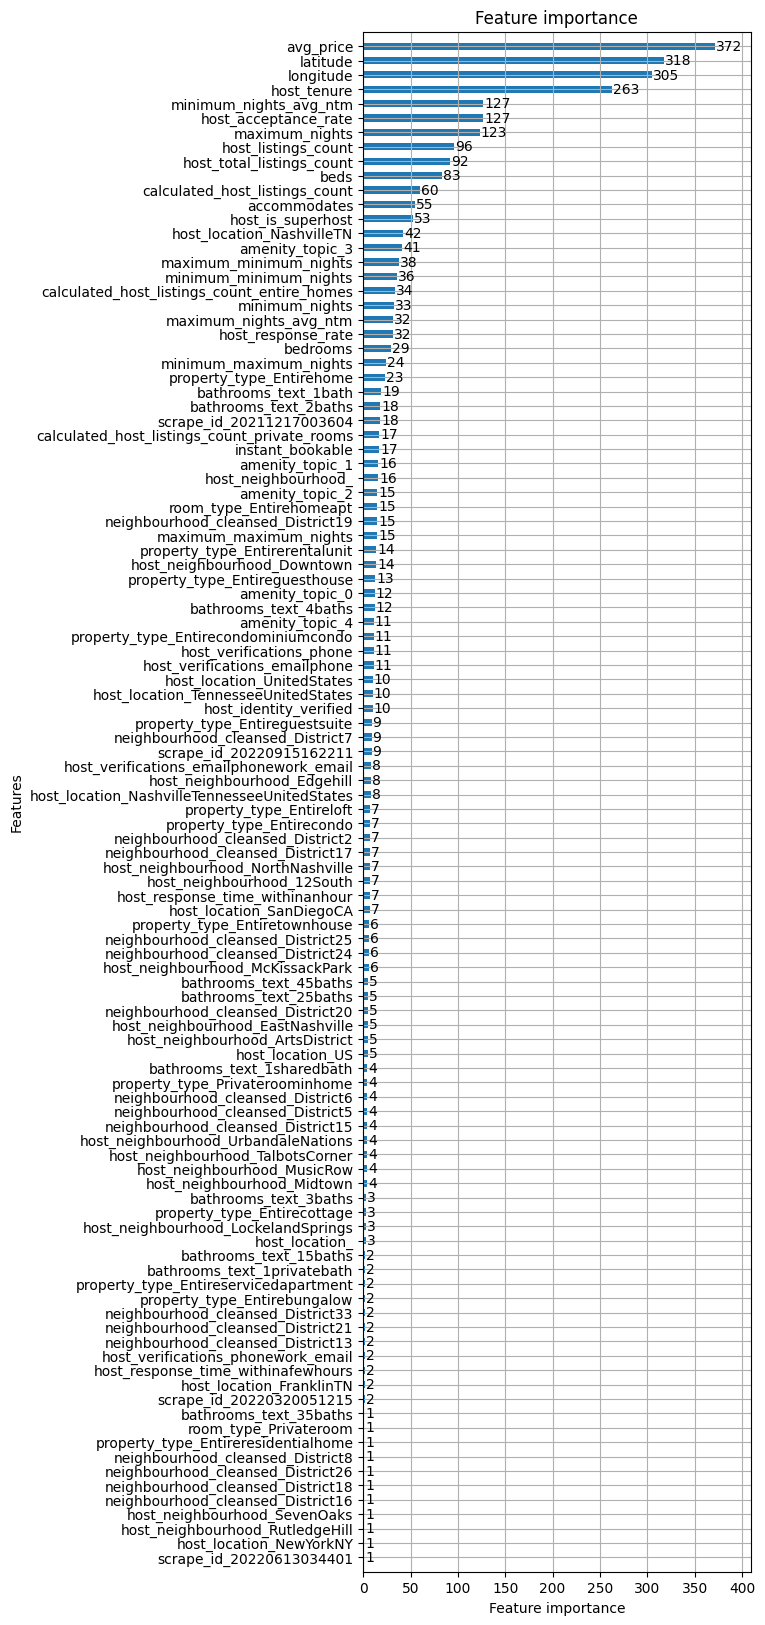

In [129]:
plt.rcParams['figure.figsize'] = (5,20)

lightgbm.plot_importance(model, height=0.5)